First, install the dev branch of `gnss_lib_py`. Don't worry if you see an ERROR regarding pip dependencies. That error means we updated colab's versions of some packages and won't affect the colab's runtime performance.

In [ ]:
# install dev branch of gnss_lib_py
import os
os.makedirs("/content/lib", exist_ok=True)
%cd /content/lib
!pip install --upgrade pip --quiet --progress-bar off
!git clone https://github.com/Stanford-NavLab/gnss_lib_py.git --quiet
%cd gnss_lib_py
!git checkout derek/android_raw
!git pull
!pip install -e . --quiet --progress-bar off
%cd /content
import site
site.main()

/content/lib
fatal: destination path 'gnss_lib_py' already exists and is not an empty directory.
/content/lib/gnss_lib_py
Already on 'derek/android_raw'
Your branch is up to date with 'origin/derek/android_raw'.
Already up to date.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gnss-lib-py (pyproject.toml) ... done
/content


# GnssLogger Android App

This tutorial walks through how to parse the files obtained from [Google's GNSSLogger Android App](https://play.google.com/store/apps/details?id=com.google.android.apps.location.gps.gnsslogger&pcampaignid=web_share). Details for each data type can be found in Google's [gps-measurement-tools](https://github.com/google/gps-measurement-tools/blob/master/LOGGING_FORMAT.md) repository.

The toggle switches on the "Home" tab of the GNSSLogger app need to be set based on the type(s) of measurements you want to log: fixes, raw, NMEA, Rinex, sensors, etc.

After data is logged, the measurements can be saved immediately or retrieved at a later time within Android's internal storage. Data can be found on the phone under a directory similar to: ``<phone>/Internal shared storage/Android/data/com.google.android.apps.location.gps.gnsslogger/files/gnss_log/``

![GnssLogger screenshot](https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/derek/android_raw/docs/source/img/gnss_logger_app.jpg)

## AA272 Tips

*   The SP3 and CLK satellite ephemeris is not usually available until 2-3 days afterwards. So you may need to wait a couple of days before you can add satellite positions with the `add_sv_states()` function and compute a WLS solution. Record early!
*   Some phones may not record data from specific satellite constellations or be able to record rinex or NMEA observations. Try recording at your home/locally before travelling anywhere to troubleshoot potential issues.
*   It's easier to delete unneeded data than repeat experiments, so I'd suggest enabling all toggle switches in the GNSSLogger App so you're recording all possible data types during your experiment.



Load `gnss_lib_py` into the Python workspace

In [ ]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# This code was designed to run on Google Colab.
# Please change the folder accordingly when attempting to run on other environments

%cd /content/gdrive/Shareddrives/AA272_Project/trial2_evgrStroll/

/content/gdrive/Shareddrives/AA272_Project/trial2_evgrStroll


## Fix Measurements from gnss_log*.txt

The first type of measurements we can get is toggling a combination of "GNSS Location", "Fused Location", and/or "Network Location" in the GNSSLogger app. These location fixes are indicated with rows that start with "Fix" in the gnss_log.txt file output.

We start by downloading an example measurement file from the GNSSLogger Android App.

Load fix data into the existing `glp.AndroidRawFixes` class.

In [ ]:
fix_data_beacon = glp.AndroidRawFixes("beacon.txt")
fix_data_moving = glp.AndroidRawFixes("moving.txt")

Based on the toggles you choose in the GNSSLogger app, you may have three different type of fixes: GNSS, network, and fused.

In [ ]:
fix_types_beacon = np.unique(fix_data_beacon["fix_provider"]).tolist()
fix_types_moving = np.unique(fix_data_moving["fix_provider"]).tolist()
print(fix_types_beacon,  fix_types_moving)

['fused', 'gnss', 'network'] ['fused', 'gnss', 'network']


In [ ]:
fixes = []
for provider in fix_types:
    fix_provider = fix_data.where("fix_provider",provider)
    fix_provider.rename({"lat_rx_deg":"lat_rx_" + provider + "_deg",
                         "lon_rx_deg":"lon_rx_" + provider + "_deg",
                         "alt_rx_m":"alt_rx_" + provider + "_m",
                         }, inplace=True)
    fixes.append(fix_provider)

## Raw Measurements from gnss_log*.txt

The secibd type of measurements we can get is by toggling "Measurements" in the GNSSLogger app. These are raw measurements indicated with rows that start with "Raw" in the gnss_log.txt file output.

We start by loading our previously downloaded raw data into the existing `glp.AndroidRawGNSS` class. When you load the data here, behind the scenes it will compute the raw pseudorange values optionally filter measurements based on a variety of conditions. See the the [filter_raw_measurements](https://gnss-lib-py.readthedocs.io/en/latest/reference/parsers/android.html#android.AndroidRawGnss.filter_raw_measurements) reference documentation for details on the options for exisitng filter types.

In [ ]:
moving_raw_data = glp.AndroidRawGnss(input_path="moving.txt",
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)

beacon_raw_data = glp.AndroidRawGnss(input_path="beacon.txt",
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)

sv_time_uncertainty removed 0
sv_time_uncertainty removed 415


In [ ]:
np.unique(moving_raw_data["gnss_id"])

array(['beidou', 'galileo', 'glonass', 'gps'], dtype=object)

In [ ]:
signalList = ('e1', 'e5a', 'l1', 'l5', 'b1')
constelList = ('galileo', 'gps', 'beidou')

moving_full_states = glp.add_sv_states(moving_raw_data, source="precise", verbose=False).where("gnss_id", constelList).where("signal_type", signalList)
beacon_full_states = glp.add_sv_states(beacon_raw_data, source="precise", verbose=False).where("gnss_id", constelList).where("signal_type", signalList)

We can then compute a "corrected" pseudorange by subtracting out each satellite's respective clock bias.

In [ ]:
beacon_true_location = np.atleast_2d(np.array([37.427778, -122.155556, 17.77]))
beacon_true_ecef = glp.geodetic_to_ecef(beacon_true_location)

In [ ]:
pos_sv_m = moving_full_states[["x_sv_m","y_sv_m","z_sv_m"]]
calculated_el_az = glp.ecef_to_el_az(beacon_true_ecef, pos_sv_m)

In [ ]:
beacon_full_states["corr_pr_m"] = beacon_full_states["raw_pr_m"] \
                         + beacon_full_states['b_sv_m']
moving_full_states["corr_pr_m"] = moving_full_states["raw_pr_m"] \
                         + moving_full_states['b_sv_m']

In [ ]:
vanilla_beacon_wls_estimate = glp.solve_wls(beacon_full_states)
vanilla_moving_wls_estimate = glp.solve_wls(moving_full_states)
vanilla_beacon_wls_estimate.rename({"lat_rx_wls_deg":"lat_rx_wls_beacon_deg",
                            "lon_rx_wls_deg":"lon_rx_wls_beacon_deg",
                            "alt_rx_wls_m":"alt_rx_wls_beacon_m",
                            }, inplace=True)

/content/lib/gnss_lib_py/gnss_lib_py/algorithms/snapshot.py:303: RuntimeWarning:

Newton Raphson did not converge.



In [ ]:
# Add Elevation and Azimuth based on prev wls

glp.add_el_az(moving_full_states,vanilla_moving_wls_estimate,inplace=True)
glp.add_el_az(beacon_full_states,vanilla_beacon_wls_estimate,inplace=True)

     # Raw    unix_millis     TimeNanos  LeapSecond  TimeUncertaintyNanos  \
0      Raw  1701228145000  148945000000         NaN                   NaN   
1      Raw  1701228145000  148945000000         NaN                   NaN   
2      Raw  1701228145000  148945000000         NaN                   NaN   
3      Raw  1701228145000  148945000000         NaN                   NaN   
4      Raw  1701228145000  148945000000         NaN                   NaN   
...    ...            ...           ...         ...                   ...   
4410   Raw  1701228305000  308945000000         NaN                   NaN   
4411   Raw  1701228305000  308945000000         NaN                   NaN   
4412   Raw  1701228305000  308945000000         NaN                   NaN   
4413   Raw  1701228305000  308945000000         NaN                   NaN   
4414   Raw  1701228305000  308945000000         NaN                   NaN   

            FullBiasNanos  BiasNanos  BiasUncertaintyNanos  \
0    -1385263

In [ ]:
moving_full_states = moving_full_states.where("el_sv_deg", 30, "geq")
moving_full_states = moving_full_states.where('cn0_dbhz',20, "geq")

In [ ]:
# Re-do WLS based on the elevation masks

vanilla_moving_wls_estimate = glp.solve_wls(moving_full_states)

/content/lib/gnss_lib_py/gnss_lib_py/algorithms/snapshot.py:303: RuntimeWarning:

Newton Raphson did not converge.



In [ ]:
import scipy.interpolate as interp


beaconConstelSatDict = {}
for signal in signalList:
  errorDict = {}
  satList = np.unique(beacon_full_states.where("signal_type",(signal))['sv_id'])

  beacon_state_by_signal = beacon_full_states.where("signal_type", (signal))

  for sat in satList:
    sat_full_state = beacon_state_by_signal.where("sv_id", sat)
    # Cut off some DGPS satellites by cn0 db
    if np.percentile(sat_full_state['cn0_dbhz'],25) < 28:
      print(signal)
      print(sat)
      continue
    sat_time = sat_full_state["gps_millis"]
    sat_ecef = np.vstack((sat_full_state["x_sv_m"], sat_full_state["y_sv_m"], sat_full_state["z_sv_m"]))
    beacon_rel_ecef = sat_ecef.T - beacon_true_ecef
    pseudo_range = sat_full_state["raw_pr_m"]
    true_range = np.linalg.norm(beacon_rel_ecef, axis=1)
    error_range = pseudo_range - true_range
    errorDict[sat] = (interp.interp1d(sat_time, error_range))

  beaconConstelSatDict[signal] = errorDict

e1
2
e5a
2
e5a
18
e5a
30
e5a
34
l1
13
l1
14
l1
22
l5
11


In [ ]:
def correct_with_error_dict(full_state, error_correction_dict):
  full_state_copy = full_state.copy()
  signalList = full_state["signal_type"]
  satList = full_state["sv_id"]
  millisList = full_state["gps_millis"]
  satBiasList = full_state['b_sv_m']
  errList = np.zeros_like(signalList, dtype=float)
  cols_to_remove = []
  for i, (signal, sat, gps_millis, sat_bias) in enumerate(zip(signalList, satList, millisList, satBiasList)):
    if sat in error_correction_dict[signal].keys():
      # Do not interpolate if Out of interpolation bounds
      try:
        errList[i] = error_correction_dict[signal][sat](gps_millis)
      # Out of interpolation range
      except:
        # Leave err list at zero
        errList[i] = -sat_bias
        # cols_to_remove.append(i)
        pass
    # Corresponding Satellite not found
    else:
      cols_to_remove.append(i)
  # with np.printoptions(threshold=np.inf):
  #   print(errList)
  full_state_copy["corr_pr_m"] = full_state_copy["raw_pr_m"] - errList
  full_state_copy.remove(cols=cols_to_remove,inplace=True)
  print(satList[np.array(cols_to_remove)])
  return full_state_copy

https://gnss-lib-py.readthedocs.io/en/latest/reference/reference.html#standard-naming-conventions
this the above out, need to convert sat position in ECEF and user position in LLA to the same coordiante system. ANd then use the same corrdinate to compute 2norm

In [ ]:
moving_full_states_dgps = correct_with_error_dict(moving_full_states, beaconConstelSatDict)
beacon_full_states_dgps = correct_with_error_dict(beacon_full_states, beaconConstelSatDict)

[22 34 25 ... 12 11 30]
[13 22 11 ... 18 30 34]


In [ ]:
np.unique(moving_full_states_dgps.where("signal_type", ("l1"))["sv_id"])

array([ 6, 17, 19, 24])

In [ ]:
# Debug Code when only_bias=True

import pandas as pd

columns = ['x_rx_m', 'y_rx_m', 'z_rx_m', 'gps_millis']
receiver_state = pd.DataFrame(columns=columns)
receiver_state['gps_millis'] = beacon_full_states_dgps['gps_millis']
receiver_state['x_rx_m'] = np.full_like(receiver_state['gps_millis'], beacon_true_ecef[0,0])
receiver_state['y_rx_m'] = np.full_like(receiver_state['gps_millis'], beacon_true_ecef[0,1])
receiver_state['z_rx_m'] = np.full_like(receiver_state['gps_millis'], beacon_true_ecef[0,2])
receiver_state_nav = glp.NavData(pandas_df=receiver_state)

beacon_wls_estimate_dgps = glp.solve_wls(beacon_full_states_dgps, only_bias=True, receiver_state=receiver_state_nav)

In [ ]:
# moving_full_states_dgps["weights"] = moving_full_states_dgps["cn0_dbhz"]**3
beacon_wls_estimate_dgps = glp.solve_wls(beacon_full_states_dgps, sv_rx_time = True)
moving_wls_estimate_dgps = glp.solve_wls(moving_full_states_dgps, sv_rx_time = True)
moving_wls_estimate_dgps.rename({"lat_rx_wls_deg":"lat_rx_wls_dgps_moving_deg",
                            "lon_rx_wls_deg":"lon_rx_wls_dgps_moving_deg",
                            "alt_rx_wls_m":"alt_rx_wls_dgps_moving_m",
                            }, inplace=True)
beacon_wls_estimate_dgps.rename({"lat_rx_wls_deg":"lat_rx_wls_dgps_beacon_deg",
                            "lon_rx_wls_deg":"lon_rx_wls_dgps_beacon_deg",
                            "alt_rx_wls_m":"alt_rx_wls_dgps_beacon_m",
                            }, inplace=True)

raw_fig = glp.plot_map(*[vanilla_moving_wls_estimate, vanilla_beacon_wls_estimate]+[fixes[1]])
raw_fig.show()
raw_fig = glp.plot_map(*[moving_wls_estimate_dgps, beacon_wls_estimate_dgps]+[fixes[1]])
raw_fig.show()

Correct offset from beacon to true location due to wls error

In [ ]:
import pandas as pd

def interpolate(ts, time):
  try:
    return ts[time]
  except:
    cni = np.argmin(np.abs(ts.index - time)) # cni = closest neighbor index
    # if closest neighbor is the smallest in time series, and time is smaller than min time, return the first value
    if cni == 0 and time < ts.index[0]:
      print("end point interpolation, with time diff of ", abs(time - ts.index[0]) / 1000, " sec")
      return ts.values[0]
    # if the closest neightbor is the largest in the time series, return the last value
    elif cni == len(ts.index) and time > ts.index[-1]:
      print("end point interpolation, with time diff of ", abs(time - ts.index[-1]) / 1000, " sec")
      return ts.values[-1]
    # else do linear interpolation
    else:
      #  scenario 1: * -----|- * (* point in time sereis, | time point)
      #.                       cni
      if time < ts.index[cni]:
        slope = (ts.values[cni - 1] - ts.values[cni])/(ts.index[cni - 1] - ts.index[cni])
        return ts.values[cni] + slope * (time - ts.index[cni])
      #  scenario 2: * -|----- * (* point in time sereis, | time point)
      #              cni
      elif time > ts.index[cni]:
        slope = (ts.values[cni + 1] - ts.values[cni])/(ts.index[cni + 1] - ts.index[cni])
        return ts.values[cni] + slope * (time - ts.index[cni])


beacon_true_location = [37.42755928, -122.15708859, 17.62]
# beacon_true_location = [37.427778, -122.155556, 17.77]

lat_diff = beacon_wls_estimate_dgps["lat_rx_wls_dgps_beacon_deg"] - beacon_true_location[0]
lat_diff_ts = pd.Series(lat_diff, index=beacon_wls_estimate_dgps["gps_millis"])
lon_diff = beacon_wls_estimate_dgps["lon_rx_wls_dgps_beacon_deg"] - beacon_true_location[1]
lon_diff_ts = pd.Series(lon_diff, index=beacon_wls_estimate_dgps["gps_millis"])
alt_diff = beacon_wls_estimate_dgps["alt_rx_wls_dgps_beacon_m"] - beacon_true_location[2]
alt_diff_ts = pd.Series(alt_diff, index=beacon_wls_estimate_dgps["gps_millis"])

# correct beacon
corrected_lat = []
for time in beacon_wls_estimate_dgps["gps_millis"]:
  corrected_lat.append(interpolate(lat_diff_ts, time))
beacon_wls_estimate_dgps["lat_rx_wls_dgps_beacon_deg"] -= corrected_lat
corrected_lon = []
for time in beacon_wls_estimate_dgps["gps_millis"]:
  corrected_lon.append(interpolate(lon_diff_ts, time))
beacon_wls_estimate_dgps["lon_rx_wls_dgps_beacon_deg"] -= corrected_lon
corrected_alt = []
for time in beacon_wls_estimate_dgps["gps_millis"]:
  corrected_alt.append(interpolate(alt_diff_ts, time))
beacon_wls_estimate_dgps["alt_rx_wls_dgps_beacon_m"] -= corrected_alt

# correct moving
corrected_lat = []
for time in moving_wls_estimate_dgps["gps_millis"]:
  corrected_lat.append(interpolate(lat_diff_ts, time))
moving_wls_estimate_dgps["lat_rx_wls_dgps_moving_deg"] -= corrected_lat
corrected_lon = []
for time in moving_wls_estimate_dgps["gps_millis"]:
  corrected_lon.append(interpolate(lon_diff_ts, time))
moving_wls_estimate_dgps["lon_rx_wls_dgps_moving_deg"] -= corrected_lon
corrected_alt = []
for time in moving_wls_estimate_dgps["gps_millis"]:
  corrected_alt.append(interpolate(alt_diff_ts, time))
moving_wls_estimate_dgps["alt_rx_wls_dgps_moving_m"] -= corrected_alt

raw_fig = glp.plot_map(*[beacon_wls_estimate_dgps, moving_wls_estimate_dgps, vanilla_moving_wls_estimate]+[fixes[1]])
raw_fig.show()

end point interpolation, with time diff of  0.578  sec
end point interpolation, with time diff of  0.578  sec
end point interpolation, with time diff of  0.578  sec


Moving average

In [ ]:
# compute moving average
def moving_average(a, n=3):
  if n%2 == 0:
    front_pad = np.array([a[0] for _ in range(n // 2)])
    end_pad = np.array([a[-1] for _ in range(n // 2 - 1)])
  else:
    front_pad = np.array([a[0] for _ in range(n // 2)])
    end_pad = np.array([a[-1] for _ in range(n // 2)])
  return np.convolve(np.hstack((front_pad, a, end_pad)), np.ones((n,))/n, mode='valid')

avg_moving_wls_estimate_dgps = moving_wls_estimate_dgps.copy()
avg_moving_wls_estimate = vanilla_moving_wls_estimate.copy()

N = 30

avg_moving_wls_estimate_dgps["lat_rx_wls_dgps_moving_deg"] = moving_average(moving_wls_estimate_dgps["lat_rx_wls_dgps_moving_deg"], n = N)
avg_moving_wls_estimate_dgps["lon_rx_wls_dgps_moving_deg"] = moving_average(moving_wls_estimate_dgps["lon_rx_wls_dgps_moving_deg"], n = N)
avg_moving_wls_estimate_dgps["alt_rx_wls_dgps_moving_m"] = moving_average(moving_wls_estimate_dgps["alt_rx_wls_dgps_moving_m"], n = N)
avg_moving_wls_estimate_dgps.rename({"lat_rx_wls_dgps_moving_deg":"lat_rx_wls_moving_AVG_dgps_deg",
                                      "lon_rx_wls_dgps_moving_deg":"lon_rx_wls_moving_AVG_dgps_deg",
                                      "alt_rx_wls_dgps_moving_m":"alt_rx_wls_moving_AVG_dgps_m",
                                      }, inplace=True)

avg_moving_wls_estimate["lat_rx_wls_deg"] = moving_average(vanilla_moving_wls_estimate["lat_rx_wls_deg"], n = N)
avg_moving_wls_estimate["lon_rx_wls_deg"] = moving_average(vanilla_moving_wls_estimate["lon_rx_wls_deg"], n = N)
avg_moving_wls_estimate["alt_rx_wls_m"] = moving_average(vanilla_moving_wls_estimate["alt_rx_wls_m"], n = N)
avg_moving_wls_estimate.rename({"lat_rx_wls_deg":"lat_rx_wls_moving_AVG_deg",
                                "lon_rx_wls_deg":"lon_rx_wls_moving_AVG_deg",
                                "alt_rx_wls_m":"alt_rx_wls_moving_AVG_m",
                                }, inplace=True)

# fixes[1]["lat_rx_gnss_deg"] = moving_average(fixes[1]["lat_rx_gnss_deg"], n=N)
# fixes[1]["lon_rx_gnss_deg"] = moving_average(fixes[1]["lon_rx_gnss_deg"], n=N)
# fixes[1]["alt_rx_gnss_m"] = moving_average(fixes[1]["alt_rx_gnss_m"], n=N)

# plotting
raw_fig = glp.plot_map(*[moving_wls_estimate_dgps, avg_moving_wls_estimate_dgps]+[fixes[1]])
raw_fig.show()
raw_fig = glp.plot_map(*[vanilla_moving_wls_estimate, avg_moving_wls_estimate]+[fixes[1]])
raw_fig.show()


In [ ]:
# compute velocity in ecef
!pip install pymap3d
import pymap3d.ecef as ecef

avg_moving_wls_velcoity_dgps = moving_wls_estimate_dgps.copy()


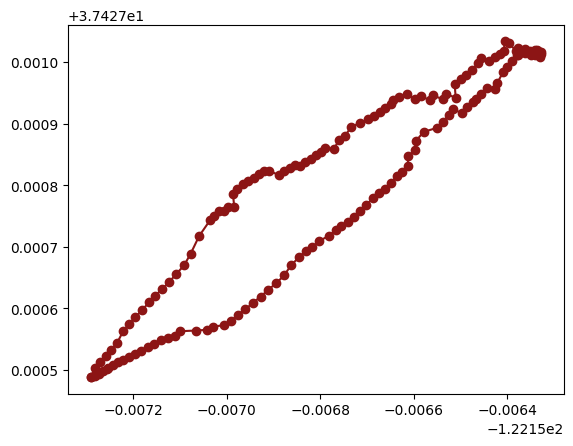

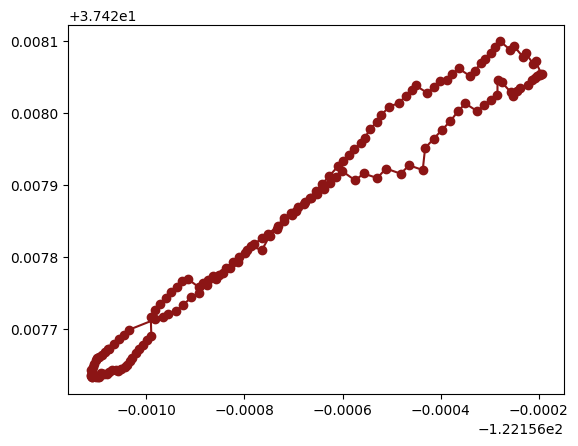

In [ ]:
# kalman smoothing
def diff(data, time):
  out = []
  for i in range(len(data)-1):
    out.append((data[i+1]-data[i])/(time[i+1]-time[i]))
  out.append(out[-1])
  return out

def kalman_smoothing(avg_moving_wls_estimate_dgps, truebeacon = True, q = 200, r = 3260000e10):
  ######## start get velocity
  avg_moving_wls_velcoity_dgps = avg_moving_wls_estimate_dgps.copy()
  try:
    ecef_storage = np.array([ecef.geodetic2ecef(avg_moving_wls_estimate_dgps["lat_rx_wls_moving_AVG_dgps_deg"][i],
                                                avg_moving_wls_estimate_dgps["lon_rx_wls_moving_AVG_dgps_deg"][i],
                                                avg_moving_wls_estimate_dgps["alt_rx_wls_moving_AVG_dgps_m"][i], ell=None, deg=True) \
                            for i in range(len(avg_moving_wls_velcoity_dgps["gps_millis"]))])
  except:
    ecef_storage = np.array([ecef.geodetic2ecef(avg_moving_wls_estimate_dgps["lat_rx_wls_moving_AVG_deg"][i],
                                                avg_moving_wls_estimate_dgps["lon_rx_wls_moving_AVG_deg"][i],
                                                avg_moving_wls_estimate_dgps["alt_rx_wls_moving_AVG_m"][i], ell=None, deg=True) \
                            for i in range(len(avg_moving_wls_velcoity_dgps["gps_millis"]))])
  avg_moving_wls_velcoity_dgps["ecef_vx"] = diff(ecef_storage[:,0], avg_moving_wls_estimate_dgps["gps_millis"])
  avg_moving_wls_velcoity_dgps["ecef_vy"] = diff(ecef_storage[:,1], avg_moving_wls_estimate_dgps["gps_millis"])
  avg_moving_wls_velcoity_dgps["ecef_vz"] = diff(ecef_storage[:,2], avg_moving_wls_estimate_dgps["gps_millis"])
  avg_moving_wls_estimate_dgps["ecef_x"] = ecef_storage[:,0]
  avg_moving_wls_estimate_dgps["ecef_y"] = ecef_storage[:,1]
  avg_moving_wls_estimate_dgps["ecef_z"] = ecef_storage[:,2]
  ######## end get velocity

  ######## start smoothing
  dim = 3 # [lat, lon]
  N = len(avg_moving_wls_velcoity_dgps["gps_millis"])
  state_his = np.zeros((dim, N))

  if truebeacon:
    # get true beacon location for starting and ending pos
    beacon_true_location = np.atleast_2d(np.array([37.42755928, -122.15708859, 17.62]))
    beacon_true_ecef = glp.geodetic_to_ecef(beacon_true_location)
    state_his[:,0] = np.array([beacon_true_ecef[0][0],\
                               beacon_true_ecef[0][1],\
                               beacon_true_ecef[0][2]])
  else:
    state_his[:,0] = np.array([np.sum(avg_moving_wls_estimate_dgps["ecef_x"][-10:])/10,\
                               np.sum(avg_moving_wls_estimate_dgps["ecef_y"][-10:])/10,\
                               np.sum(avg_moving_wls_estimate_dgps["ecef_z"][-10:])/10])

  cov_his = np.zeros((dim, dim, N))
  cov_his[:,:,0] = np.eye(dim) * 2

  predicted_mu_his = np.zeros((dim, N))
  predicted_cov_his = np.zeros((dim, dim, N))


  # Q = np.eye(dim) * 1e15
  # R = np.eye(dim) * 1e30
  Q = np.eye(dim) * q
  R = np.eye(dim) * r

  A = np.eye(dim)
  C = np.eye(dim)

  # forward pass KF
  for i in range(1,len(avg_moving_wls_velcoity_dgps["gps_millis"])):  # for each time point in acc
    # predict
    dt = (avg_moving_wls_velcoity_dgps["gps_millis"][i]-avg_moving_wls_velcoity_dgps["gps_millis"][i-1])
    v = np.array([avg_moving_wls_velcoity_dgps["ecef_vx"][i],
                  avg_moving_wls_velcoity_dgps["ecef_vy"][i],
                  avg_moving_wls_velcoity_dgps["ecef_vz"][i]])
    state_his[:,i] = A @ state_his[:,i-1]+ dt * v
    cov_his[:,:,i] = A @ cov_his[:,:,i-1] @ A.T + Q
    predicted_mu_his[:,i] = state_his[:,i]
    predicted_cov_his[:,:,i] = cov_his[:,:,i]

    # update
    y = np.array([avg_moving_wls_estimate_dgps["ecef_x"][i],
                  avg_moving_wls_estimate_dgps["ecef_y"][i],
                  avg_moving_wls_estimate_dgps["ecef_z"][i]])
    K = cov_his[:,:,i] @ C.T @ np.linalg.inv(C @ cov_his[:,:,i] @ C.T + R)
    # gain_his[:,:,i] = K  # gain at i = 0 is zeros
    state_his[:,i] += K @ (y - C @ state_his[:,i])
    cov_his[:,:,i] -= K @ C @ cov_his[:,:,i]

  # terminal position is the same as the staritng position
  state_his[:,-1] = state_his[:,0]

  # backward pass KF
  for i in range(len(avg_moving_wls_velcoity_dgps["gps_millis"])-2, -1, -1):
    K = cov_his[:,:,i] @ A.T @ np.linalg.inv(predicted_cov_his[:,:,i+1])
    state_his[:,i] = state_his[:,i] + K @ (state_his[:,i+1] - predicted_mu_his[:,i+1])
  ######## end smoothing

  # convert back from ecef to lla
  lla_storage = np.array([ecef.ecef2geodetic(state_his[0,i],
                                            state_his[1,i],
                                            state_his[2,i], ell=None, deg=True) \
                          for i in range(len(avg_moving_wls_velcoity_dgps["gps_millis"]))])
  return lla_storage

lla_storage_dgps = kalman_smoothing(avg_moving_wls_estimate_dgps, truebeacon=False)
lla_storage = kalman_smoothing(avg_moving_wls_estimate, truebeacon=False)

import matplotlib.pyplot as plt
plt.plot(lla_storage[:,1], lla_storage[:,0])
plt.show()
plt.plot(lla_storage_dgps[:,1], lla_storage_dgps[:,0])
plt.show()

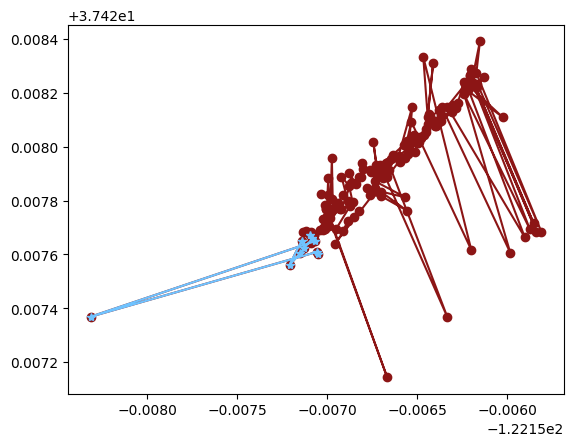

In [ ]:
import matplotlib.pyplot as plt
plt.plot(moving_wls_estimate_dgps["lon_rx_wls_dgps_moving_deg"], moving_wls_estimate_dgps["lat_rx_wls_dgps_moving_deg"])
plt.plot(moving_wls_estimate_dgps["lon_rx_wls_dgps_moving_deg"][-10:], moving_wls_estimate_dgps["lat_rx_wls_dgps_moving_deg"][-10:])
plt.show()

In [ ]:
ksmooth_wls_estimate_dgps = moving_wls_estimate_dgps.copy()
ksmooth_wls_estimate_dgps["lat_rx_wls_moving_ksmooth_dgps_deg"] = lla_storage_dgps[:,0]
ksmooth_wls_estimate_dgps["lon_rx_wls_moving_ksmooth_dgps_deg"] = lla_storage_dgps[:,1]
ksmooth_wls_estimate_dgps["alt_rx_wls_moving_ksmooth_dgps_m"] = lla_storage_dgps[:,2]
ksmooth_wls_estimate_dgps = ksmooth_wls_estimate_dgps.remove("lat_rx_wls_dgps_moving_deg")
ksmooth_wls_estimate_dgps = ksmooth_wls_estimate_dgps.remove("lon_rx_wls_dgps_moving_deg")
ksmooth_wls_estimate_dgps = ksmooth_wls_estimate_dgps.remove("alt_rx_wls_dgps_moving_m")

ksmooth_wls_estimate = moving_wls_estimate_dgps.copy()
ksmooth_wls_estimate["lat_rx_wls_moving_ksmooth_deg"] = lla_storage[:,0]
ksmooth_wls_estimate["lon_rx_wls_moving_ksmooth_deg"] = lla_storage[:,1]
ksmooth_wls_estimate["alt_rx_wls_moving_ksmooth_m"] = lla_storage[:,2]
ksmooth_wls_estimate = ksmooth_wls_estimate.remove("lat_rx_wls_dgps_moving_deg")
ksmooth_wls_estimate = ksmooth_wls_estimate.remove("lon_rx_wls_dgps_moving_deg")
ksmooth_wls_estimate = ksmooth_wls_estimate.remove("alt_rx_wls_dgps_moving_m")
raw_fig = glp.plot_map(*[ksmooth_wls_estimate_dgps] +[fixes[1]])
raw_fig.show()
raw_fig = glp.plot_map(*[ksmooth_wls_estimate]+[fixes[1]])
raw_fig.show()
raw_fig = glp.plot_map(*[ksmooth_wls_estimate_dgps, ksmooth_wls_estimate]+[fixes[1]])
raw_fig.show()
# raw_fig = glp.plot_map(*[ksmooth_wls_estimate_dgps, ksmooth_wls_estimate, beacon_wls_estimate_dgps, moving_wls_estimate_dgps, vanilla_moving_wls_estimate, avg_moving_wls_estimate_dgps, avg_moving_wls_estimate]+[fixes[1]])
# raw_fig.show()

In [ ]:
# error computation
ecef_storage_true = np.vstack((fixes[1]["lat_rx_gnss_deg"], fixes[1]["lon_rx_gnss_deg"]))

def compute_err(data, raw = False):
  if raw:
    ecef_storage_data = np.vstack((data[:,0], data[:,1]))
    error = np.linalg.norm(ecef_storage_true - ecef_storage_data, axis = 0)
    return np.sum(error)/len(error) * 111139
  else:
    ecef_storage_data = np.vstack((data[data.rows[-3]], data[data.rows[-2]]))
    error = np.linalg.norm(ecef_storage_true - ecef_storage_data, axis = 0)
    return np.sum(error)/len(error) * 111139

print(compute_err(lla_storage_dgps, raw = True))
print(compute_err(lla_storage, raw = True))

7.7642626697006545
12.619624239479219


In [ ]:
# optimization
# from tqdm.notebook import tqdm
# min_err = float("inf")
# best_q = 0
# for i in tqdm(np.arange(1000000, 5000000, 10000)):
#   lla_storage_dgps = kalman_smoothing(avg_moving_wls_estimate_dgps, truebeacon=True, r = i)
#   err = compute_err(lla_storage_dgps, raw = True)
#   if err < min_err:
#     min_err = err
#     best_q = i

# print(best_q)



In [ ]:
ecef_storage_true = np.vstack((fixes[1]["lat_rx_gnss_deg"], fixes[1]["lon_rx_gnss_deg"]))
ecef_storage_true.shape

(2, 161)

In [ ]:
fused_timeList = fixes[0]['gps_millis']
fused_latList = fixes[0]['lat_rx_fused_deg']
fused_lonList = fixes[0]['lon_rx_fused_deg']
fused_altList = np.zeros_like(fused_lonList)

fused_time2lat = interp.interp1d(fused_timeList, fused_latList, fill_value="extrapolate")
fused_time2lon = interp.interp1d(fused_timeList, fused_lonList, fill_value="extrapolate")

In [ ]:
# Create fused lat/lon/alt vectors that are equiv in time as the dgps outputs

fused_timeList_like_dgps = moving_wls_estimate_dgps['gps_millis']
fused_latList_like_dgps = fused_time2lat(fused_timeList_like_dgps)
fused_lonList_like_dgps = fused_time2lon(fused_timeList_like_dgps)
fused_altList_like_dgps = np.zeros_like(fused_timeList_like_dgps)

dgps_latList = moving_wls_estimate_dgps['lat_rx_wls_dgps_moving_deg']
dgps_lonList = moving_wls_estimate_dgps['lon_rx_wls_dgps_moving_deg']
dgps_altList = np.zeros_like(fused_timeList_like_dgps)

In [ ]:
# Create fused lat/lon/alt vectors that are equiv in time as the non-dgps outputs

fused_timeList_like_vanilla = vanilla_moving_wls_estimate['gps_millis']
fused_latList_like_vanilla = fused_time2lat(fused_timeList_like_vanilla)
fused_lonList_like_vanilla = fused_time2lon(fused_timeList_like_vanilla)
fused_altList_like_vanilla = np.zeros_like(fused_timeList_like_vanilla)

dgps_latList = moving_wls_estimate_dgps['lat_rx_wls_dgps_moving_deg']
dgps_lonList = moving_wls_estimate_dgps['lon_rx_wls_dgps_moving_deg']
dgps_altList = np.zeros_like(fused_timeList_like_dgps)


vanilla_latList = vanilla_moving_wls_estimate['lat_rx_wls_deg']
vanilla_lonList = vanilla_moving_wls_estimate['lon_rx_wls_deg']
vanilla_altList = np.zeros_like(fused_timeList_like_vanilla)

In [ ]:
# Get beacon accuracy
fused_timeList_like_vanilla_beacon = vanilla_beacon_wls_estimate['gps_millis']
beacon_latList = vanilla_beacon_wls_estimate['lat_rx_wls_beacon_deg']
beacon_lonList = vanilla_beacon_wls_estimate['lon_rx_wls_beacon_deg']
beacon_altList = np.zeros_like(fused_timeList_like_vanilla_beacon)

In [ ]:
# Moving Average
dgps_latList = avg_moving_wls_estimate_dgps['lat_rx_wls_moving_AVG_dgps_deg']
dgps_lonList = avg_moving_wls_estimate_dgps['lon_rx_wls_moving_AVG_dgps_deg']
dgps_altList = np.zeros_like(fused_timeList_like_dgps)

vanilla_latList = avg_moving_wls_estimate['lat_rx_wls_moving_AVG_deg']
vanilla_lonList = avg_moving_wls_estimate['lon_rx_wls_moving_AVG_deg']
vanilla_altList = np.zeros_like(fused_timeList_like_dgps)

In [ ]:
# Moving Average + EKF forward/backward
dgps_latList = ksmooth_wls_estimate_dgps["lat_rx_wls_moving_ksmooth_dgps_deg"]
dgps_lonList = ksmooth_wls_estimate_dgps["lon_rx_wls_moving_ksmooth_dgps_deg"]
dgps_altList = np.zeros_like(fused_timeList_like_dgps)

vanilla_latList = ksmooth_wls_estimate["lat_rx_wls_moving_ksmooth_deg"]
vanilla_lonList = ksmooth_wls_estimate["lon_rx_wls_moving_ksmooth_deg"]
vanilla_altList = np.zeros_like(fused_timeList_like_vanilla)

In [ ]:
x0 = np.atleast_2d(np.array([37.427867928496326, -122.15663243890485, 0]))

In [ ]:
local_frame = glp.LocalCoord.from_geodetic(x0)

In [ ]:
ned_fused = local_frame.geodetic_to_ned(np.array([fused_latList_like_dgps, fused_lonList_like_dgps, fused_altList_like_dgps]))
ned_dgps = local_frame.geodetic_to_ned(np.array([dgps_latList, dgps_lonList, dgps_altList]))
ned_vanilla = local_frame.geodetic_to_ned(np.array([vanilla_latList, vanilla_lonList, vanilla_altList]))
ned_vanilla_beacon = local_frame.geodetic_to_ned(np.array([beacon_latList, beacon_lonList, beacon_altList]))

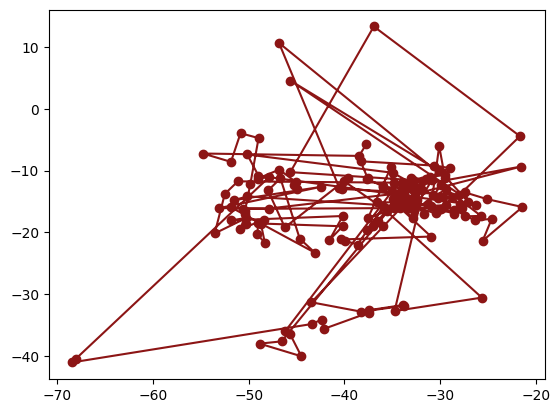

In [ ]:
mean = np.mean(ned_vanilla_beacon[0:2, :], axis=1)
cov = np.cov(ned_vanilla_beacon[0:2, :], rowvar=1)
plt.plot(ned_vanilla_beacon[1,:], ned_vanilla_beacon[0,:])

In [ ]:
dgps_ned_diff_sq = np.sum((ned_dgps[0:2,:] - ned_fused[0:2,:])**2, axis=0)
fused_dgps_rmse = np.sqrt(np.sum(dgps_ned_diff_sq) / len(fused_timeList_like_dgps))

vanilla_ned_diff_sq = np.sum((ned_vanilla[0:2,:] - ned_fused[0:2,:])**2, axis=0)
fused_vanilla_rmse = np.sqrt(np.sum(vanilla_ned_diff_sq) / len(fused_timeList_like_vanilla))

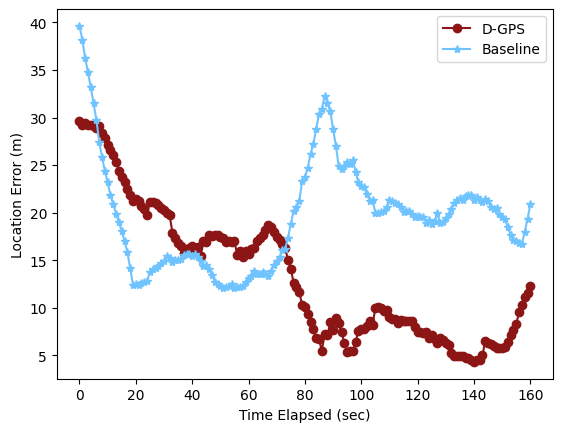

In [ ]:
plt.plot((fused_timeList_like_dgps - fused_timeList_like_dgps[0])/1e3, np.sqrt(dgps_ned_diff_sq))
plt.plot((fused_timeList_like_vanilla - fused_timeList_like_vanilla[0])/1e3, np.sqrt(vanilla_ned_diff_sq))
plt.xlabel("Time Elapsed (sec)")
plt.ylabel("Location Error (m)")
plt.legend(("D-GPS", "Baseline"))

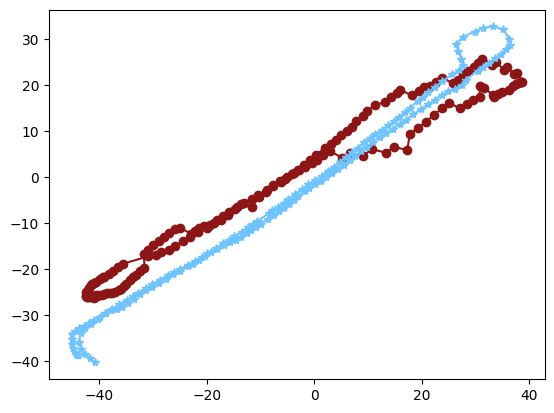

In [ ]:
plt.plot(ned_dgps[1,:], ned_dgps[0,:])
plt.plot(ned_fused[1,:], ned_fused[0,:])
plt.show()

In [ ]:
fused_dgps_rmse


15.19576175708749

In [ ]:
fused_vanilla_rmse

20.344896583808026